![](../images/itam_logo.png)

M. Sc. Liliana Millán Núñez liliana.millan@itam.mx

Octubre 2020

### Decision Trees 

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
titanic = pd.read_csv("/home/silil/Documents/itam/mineria_datos_licenciatura/data/titanic/titanic.csv")
titanic.shape

(887, 8)

Cambiamos los nombres de las columnas a minúsculas, sin espacios o caracteres raros.

In [96]:
titanic.rename(columns={col: col.lower() for col in titanic.columns.values}, inplace=True)
titanic.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'siblings/spouses aboard',
       'parents/children aboard', 'fare'],
      dtype='object')

In [97]:
titanic.rename(columns={col: col.replace(' ','_').replace('/','_') for col in titanic.columns.values}, inplace=True)
titanic.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'siblings_spouses_aboard',
       'parents_children_aboard', 'fare'],
      dtype='object')

In [98]:
titanic.dtypes

survived                     int64
pclass                       int64
name                        object
sex                         object
age                        float64
siblings_spouses_aboard      int64
parents_children_aboard      int64
fare                       float64
dtype: object

La implementación de árboles de scikit learn **no** permite ocupar datos de tipo categórico (╯°□°)╯︵ ┻━┻ por lo que tendremos que modificar la variable sexo a un valor de 0 o 1. 

In [99]:
## Transformación de variables CART no acepta valores categóricos 
titanic.sex.mask(titanic.sex == 'female','1', inplace=True)
titanic.sex.mask(titanic.sex == 'male', '0', inplace=True)
titanic.head()

,survived,pclass,name,sex,age,siblings_spouses_aboard,parents_children_aboard,fare
0,0,3,Mr. Owen Harris Braund,0,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,1,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,1,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,1,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,0,35.0,0,0,8.0500


In [100]:
y = titanic.survived
y.shape

(887,)

Seleccionamos las variables que ocuparemos para predecir si alguien sobrevivirá o no. 

¿Por qué no consideramos el nombre?

In [101]:
X = titanic.filter(['pclass','sex','age','siblings_spouses_aboard','parents_children_aboard','fare'], axis=1)
X.columns

Index(['pclass', 'sex', 'age', 'siblings_spouses_aboard',
       'parents_children_aboard', 'fare'],
      dtype='object')

Hagamos la separación de nuestro set de datos en train y test. 

¿Se puede hacer aleatorio?

In [102]:
np.random.seed(201026)

In [103]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=111)
print("\nX_train, y_train: ", (X_train.shape, y_train.shape))
print("\nX_test, y_test: ", (X_test.shape, y_test.shape))


X_train, y_train:  ((620, 6), (620,))

X_test, y_test:  ((267, 6), (267,))


In [104]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt

%matplotlib inline

# configuramos los hiperparámetros de nuestro árbol. En nuesro caso definiremos el criterio de 
# ganancia de información y cuántos elementos queremos que tenga una hoja. Puedes ver todos los hiperparámetros
# que tiene un árbol en la API de referencia de scikit-learn (ver Referencias).
dt = DecisionTreeClassifier(criterion="gini", min_samples_leaf=5, random_state=123)

# Instanciaremos y entrenaremos el árbol con nuestros datos de entrenamiento
dt.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5, random_state=123)

Podemos conocer qué variables son los que están aportando mayor información para predecir:

In [105]:
dt.feature_importances_

array([0.10579295, 0.43408322, 0.23854846, 0.02833762, 0.00787941,
       0.18535834])

Como verás solo te regresa por columna cuál es el score de importancia, dado que no necesariamente sabemos cuál es el órden de las columnas, es mejor ver la importancia a través del siguiente código: 

In [106]:
feature_importances_df = pd.DataFrame({'feature': X.columns.values, 
                                       'importance': dt.feature_importances_})

In [107]:
feature_importances_df.sort_values(by="importance", ascending=False)

,feature,importance
1,sex,0.434083
2,age,0.238548
5,fare,0.185358
0,pclass,0.105793
3,siblings_spouses_aboard,0.028338
4,parents_children_aboard,0.007879


Ahora podemos ver que la variable que más información está aportando a la clasificación de sobrevivencia o no es el sexo y la edad del pasajero. Eso significa que la raíz de nuestro árbol es el sexo.

También podemos ver la construcción del árbol: 

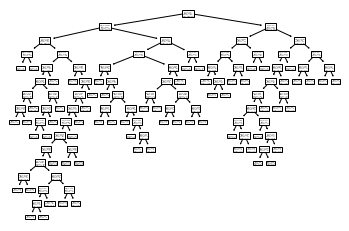

In [108]:
plt.clf() # nos permite borrar cualquier figura existente hasta este momento para tener un canvas en blanco
plot_tree(dt)
plt.show()

También podemos obetener las reglas generadas por el árbol

In [109]:
from sklearn.tree import export_text

decisions = export_text(dt, feature_names=X.columns.to_list())
print(decisions)

|--- sex <= 0.50
|   |--- fare <= 26.27
|   |   |--- age <= 13.50
|   |   |   |--- fare <= 15.57
|   |   |   |   |--- class: 1
|   |   |   |--- fare >  15.57
|   |   |   |   |--- class: 1
|   |   |--- age >  13.50
|   |   |   |--- fare <= 7.91
|   |   |   |   |--- age <= 32.50
|   |   |   |   |   |--- age <= 24.50
|   |   |   |   |   |   |--- fare <= 7.24
|   |   |   |   |   |   |   |--- fare <= 7.17
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- fare >  7.17
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- fare >  7.24
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- age >  24.50
|   |   |   |   |   |   |--- fare <= 7.87
|   |   |   |   |   |   |   |--- fare <= 7.76
|   |   |   |   |   |   |   |   |--- fare <= 7.23
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- fare >  7.23
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- fare >  7.76
| 

Dado que decidimos hacer un hold-out solo tenemos un set de pruebas para "probar" por lo que ocuparemos ese set de pruebas para poder ver el desempeño del modelo: 

+ Accuracy
+ ROC y AUC
+ Matriz de confusión
+ Precision
+ Recall
+ F1-score

Primero haremos la predicción sobre el set de pruebas. Si solo pedimos predict, nos regresará las etiquetas asociadas a la predicción, sin embargo el *threshold* no lo escogimos nosotros y no sabemos si en negocio eso tiene sentido. Es por eso, que podemos pedir el score de la predicción para que nosotros decidamos el punto de corte o *threshold* que mejor se acomoda al problema de negocio que queremos resolver.

In [110]:
# etiquetas asociadas
predictions_labels = dt.predict(X_test)
predictions_labels[:10]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0])

In [111]:
# scores asociados, te regresará un score. Para ver a quién pertenece cada score puedes ocupar el atributo classes_
predictions_scores = dt.predict_proba(X_test)
predictions_scores[:10]

array([[0.5       , 0.5       ],
       [0.85714286, 0.14285714],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.4       , 0.6       ],
       [0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.28571429, 0.71428571],
       [0.42857143, 0.57142857],
       [1.        , 0.        ]])

In [112]:
dt.classes_

array([0, 1])

Esto significa que la primer columna de scores están asociados a la clase 0 (no sobrevivió), y la segunda a la clase 1 (sobrevivió).


In [113]:
titanic.survived.value_counts(normalize=True)

0    0.614431
1    0.385569
Name: survived, dtype: float64

#### Accuracy 

In [114]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predictions_labels)

0.8202247191011236

#### ROC y AUC

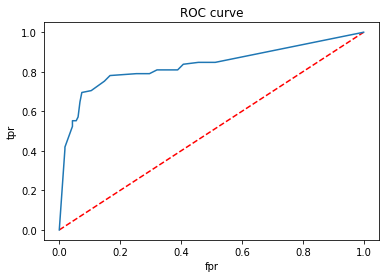

In [115]:
from sklearn.metrics import roc_auc_score, roc_curve 

# tenemos que pasar primero la etiqueta real y luego el score asociado.
# pos_label nos permite definir cuál es la etiqueta positiva (para el cálculo de lo TP, FP, TN y FN)
# la salida de roc_curve son los valores de la x (FPR), los valores de la y (TPR) y el threshold de cada punto en la curva.
fpr, tpr, thresholds_roc = roc_curve(y_test, predictions_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

In [116]:
auc = roc_auc_score(y_test, predictions_scores[:,1])
auc

0.8321575543797766

#### Matriz de confusión

De la documentación de sklearn de [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

+ [0,0]: True negatives
+ [0,1]: False positives 
+ [1,0]: False negatives
+ [1,1]: True positives

In [117]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions_labels)

array([[145,  17],
       [ 31,  74]])

+ ¿Cuántos FN tenemos? 
+ ¿Cuántos TP tenemos? 

¿Está "bien" el modelo de acuerdo a nuestro objetivo?

#### Precision y recall

In [118]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, predictions_scores[:,1])

(precision, recall, thresholds)

(array([0.39325843, 0.51744186, 0.54601227, 0.57142857, 0.57432432,
        0.61594203, 0.62043796, 0.63358779, 0.66935484, 0.75229358,
        0.76699029, 0.81318681, 0.85882353, 0.86075949, 0.85714286,
        0.86567164, 0.89230769, 0.88709677, 0.93617021, 0.93478261,
        1.        ]),
 array([1.        , 0.84761905, 0.84761905, 0.83809524, 0.80952381,
        0.80952381, 0.80952381, 0.79047619, 0.79047619, 0.78095238,
        0.75238095, 0.7047619 , 0.6952381 , 0.64761905, 0.57142857,
        0.55238095, 0.55238095, 0.52380952, 0.41904762, 0.40952381,
        0.        ]),
 array([0.        , 0.11111111, 0.14285714, 0.16666667, 0.2       ,
        0.22222222, 0.25      , 0.28571429, 0.33333333, 0.4       ,
        0.5       , 0.57142857, 0.6       , 0.66666667, 0.71428571,
        0.75      , 0.8       , 0.875     , 0.88888889, 1.        ]))

<Figure size 432x288 with 0 Axes>

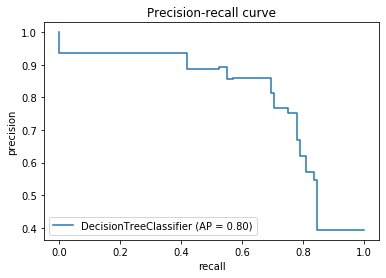

In [119]:
from sklearn.metrics import plot_precision_recall_curve

plt.clf()
plot_precision_recall_curve(dt, X_test, y_test)
plt.title("Precision-recall curve")
plt.xlabel("recall")
plt.ylabel("precision")
plt.show()

#### F1 score

En particular la implementación que tiene sklearn nos queda corta pues solo obtiene el f1 score general, nosotros lo queremos obtener por cada punto en la curva ROC. 

Pero nosotros podemos hacer nuestra propia implementación

In [120]:
from sklearn.metrics import f1_score

f1_score = f1_score(y_test, predictions_labels, labels=[0,1],  pos_label=1)
f1_score

0.7551020408163266

#### Punto de corte del score del modelo 

In [121]:
metricas_df = pd.DataFrame({'thresholds': thresholds_roc, 'tpr': tpr, 'fpr': fpr})

In [122]:
metricas_df

,thresholds,tpr,fpr
0,2.000000,0.000000,0.000000
1,1.000000,0.409524,0.018519
2,0.888889,0.419048,0.018519
3,0.875000,0.523810,0.043210
4,0.800000,0.552381,0.043210
5,0.750000,0.552381,0.055556
6,0.714286,0.571429,0.061728
7,0.666667,0.647619,0.067901
8,0.600000,0.695238,0.074074
9,0.571429,0.704762,0.104938


Todavía nos faltan los TNR y FNR, ¿cómo podemos calcular estos? 

De la definición de TP, FP, TN y FN: 

+ TP: El modelo predice 1 y la etiqueta real es 1
+ FP: El modelo predice 1 y la etiqueta real es 0
+ TN: El modelo predice 0 y la etiqueta real es 0
+ FN: El modelo predice 0 y la etiqueta real es 1 

Entonces, cuando expresamos los TP y FP como porcentajes, podemos obtener los TNR y FNR correspondientes con: 

$$FNR = 1 - TPR$$

$$TNR = 1- FPR$$

In [123]:
metricas_df['tnr'] = 1 - metricas_df['fpr']
metricas_df['fnr'] = 1 - metricas_df['tpr']

Ahora agregaremos el precision y recall

In [124]:
metricas_df['precision'] = metricas_df.tpr/(metricas_df.tpr + metricas_df.fpr)
metricas_df['recall'] = metricas_df.tpr/(metricas_df.tpr + metricas_df.fnr)

In [125]:
metricas_df

,thresholds,tpr,fpr,tnr,fnr,precision,recall
0,2.000000,0.000000,0.000000,1.000000,1.000000,NaN,0.000000
1,1.000000,0.409524,0.018519,0.981481,0.590476,0.956737,0.409524
2,0.888889,0.419048,0.018519,0.981481,0.580952,0.957678,0.419048
3,0.875000,0.523810,0.043210,0.956790,0.476190,0.923795,0.523810
4,0.800000,0.552381,0.043210,0.956790,0.447619,0.927450,0.552381
5,0.750000,0.552381,0.055556,0.944444,0.447619,0.908616,0.552381
6,0.714286,0.571429,0.061728,0.938272,0.428571,0.902507,0.571429
7,0.666667,0.647619,0.067901,0.932099,0.352381,0.905102,0.647619
8,0.600000,0.695238,0.074074,0.925926,0.304762,0.903714,0.695238
9,0.571429,0.704762,0.104938,0.895062,0.295238,0.870399,0.704762


La última tabla que generamos deberá se la tabla sobre la que tomaremos nuestras decisiones del modelo. Por ejemplo, si estuviermos dispuestos a solo hacer 5% de errores, ¿qué porcentaje de TPs tendremos, con cuánto presicion y recall?

En este caso nuestro threshold nos servirá para indicar a partir de qué score nosotros diremos que la etiqueta es 1. ¿Cuál es ese threshold? 

### Cambiando las etiquetas a nuestro punto de corte

In [126]:
new_labels = [1 if score >= 0.8000 else 0 for score in predictions_scores[:,1]]

Veamos cómo al cambiar el punto de corte también cambiaremos la matriz de confusión

In [127]:
confusion_matrix(y_test, new_labels)

array([[155,   7],
       [ 47,  58]])

Ahora nos equivocamos menos en los FP, eso es porque decidimos que nuestro punto de corte tuviera un máximo de 5% de FPs

### Solución 2. Ocupando *cross validation*

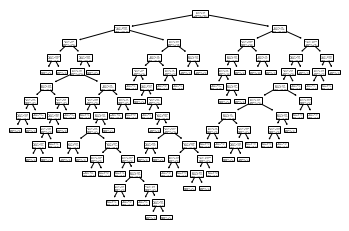

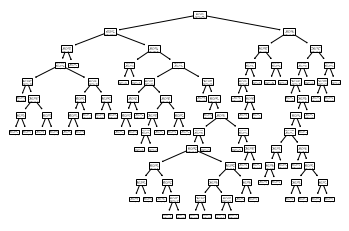

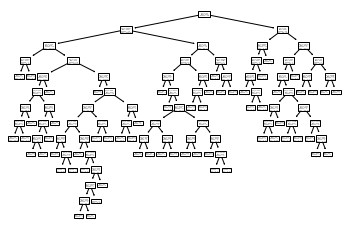

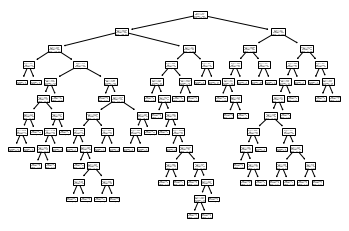

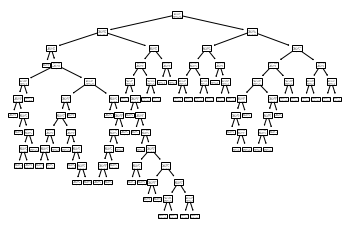

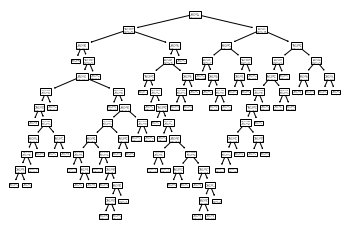

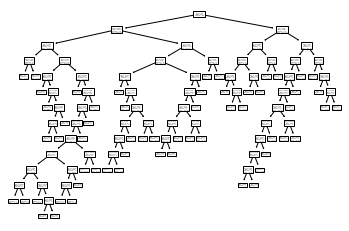

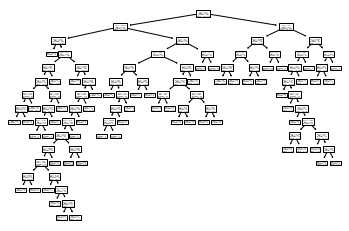

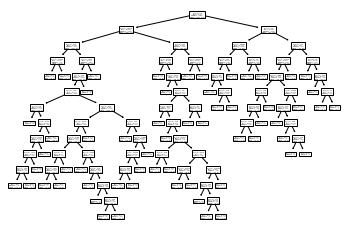

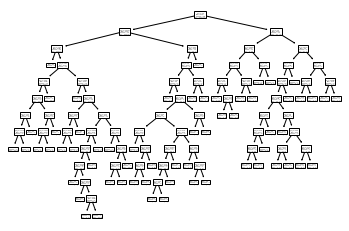

In [128]:
# construyamos el arbol pero durante su entrenamiento utilicemos k-cross validation de 10
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt

%matplotlib inline

# definimos los hiperparámetros del árbol
dt = DecisionTreeClassifier(criterion="gini", min_samples_leaf=5, random_state=123)

folds = {}

kfold = KFold(10)
split = 1

for train_index, test_index in kfold.split(X_train, y_train):
    dt.fit(X_train.iloc[train_index,:], y_train.iloc[train_index])
    folds['fold_{}'.format(split)] = { 
        'labels': dt.predict(X_train.iloc[test_index,:]),
        'scores': dt.predict_proba(X_train.iloc[test_index,:]),
        'x_test': X_train.iloc[test_index],
        'y_test': y_train.iloc[test_index]
    }
    plt.clf()
    plot_tree(dt)
    plt.show()
    split+= 1

### Medición de desempeño para cada *fold* 

#### ROC

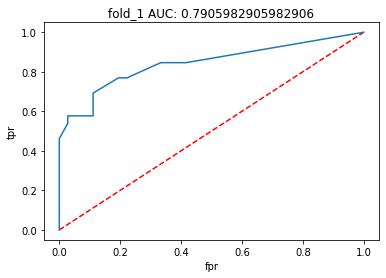

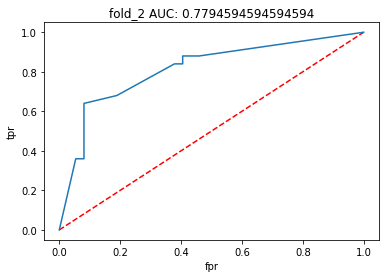

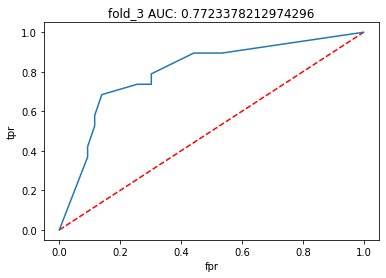

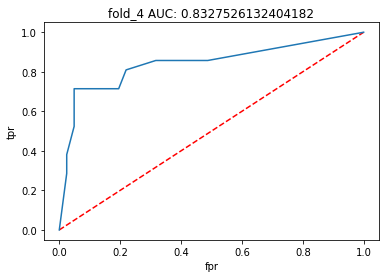

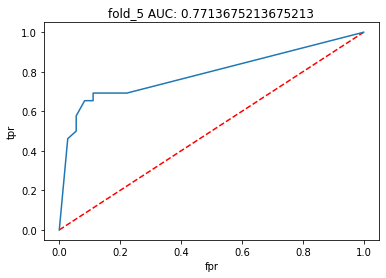

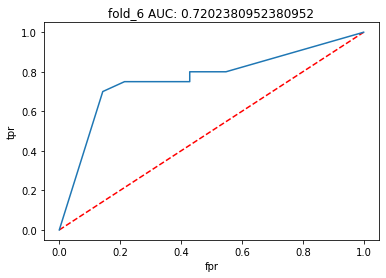

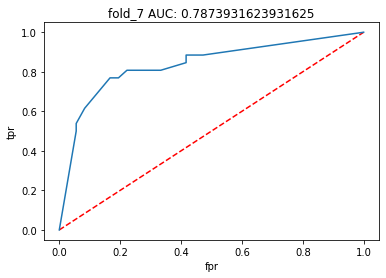

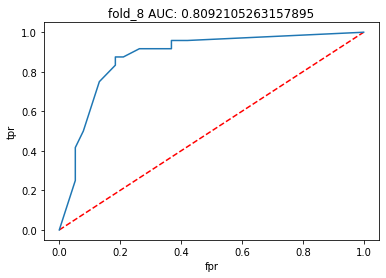

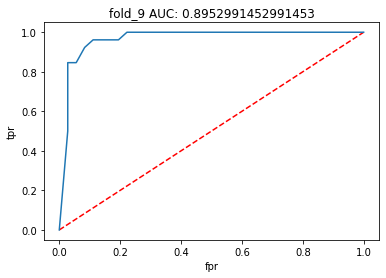

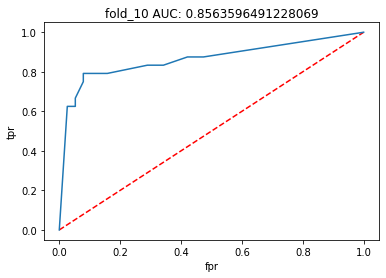

In [129]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve

fpr_tpr = {}

for key, value in folds.items(): 
    #y_true, y_score, para saber el orden en el que aparecen los scores deberás ver lo que devuelve el atributo classes_
    # por ejemplo: dt.classes_ devuelve [0,1] lo que significa que el primer score corresponde a la etiqueta 0
    # y la segunda a la etiqueta 1.
    fpr, tpr, thresholds = roc_curve(folds[key]['y_test'], folds[key]['scores'][:,1], pos_label=1)
    fpr_tpr[key] = {'fpr': fpr, 'tpr': tpr}

    
for key, vlaue in fpr_tpr.items():
    plt.clf()
    plt.plot([0, 1], [0, 1], 'k--', c="red")
    plt.plot(fpr_tpr[key]['fpr'], fpr_tpr[key]['tpr'], label=key)
    plt.title(key + " AUC: " + str(roc_auc_score(folds[key]['y_test'], folds[key]['labels'])))
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()

#### Matriz de confusión

De la documentación de sklearn de [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

+ [0,0]: True negatives
+ [0,1]: False positives 
+ [1,0]: False negatives
+ [1,1]: True positives

In [130]:
for key, value in folds.items():
    print("\n", key, ":\n", confusion_matrix(folds[key]['y_test'], folds[key]['labels']))
    


 fold_1 :
 [[32  4]
 [ 8 18]]

 fold_2 :
 [[34  3]
 [ 9 16]]

 fold_3 :
 [[37  6]
 [ 6 13]]

 fold_4 :
 [[39  2]
 [ 6 15]]

 fold_5 :
 [[32  4]
 [ 9 17]]

 fold_6 :
 [[29 13]
 [ 5 15]]

 fold_7 :
 [[29  7]
 [ 6 20]]

 fold_8 :
 [[33  5]
 [ 6 18]]

 fold_9 :
 [[34  2]
 [ 4 22]]

 fold_10 :
 [[35  3]
 [ 5 19]]


### Precision y recall


In [131]:
precision_recall = {}

for key, value in folds.items():
    precision, recall, thresholds = precision_recall_curve(folds[key]['y_test'], folds[key]['scores'][:,1])
    precision_recall[key] = {'precision': precision, 'recall': recall, 'thresholds': thresholds}

In [132]:
precision_recall['fold_1']

{'precision': array([0.41935484, 0.59459459, 0.61111111, 0.62857143, 0.64705882,
        0.71428571, 0.74074074, 0.81818182, 0.78947368, 0.88235294,
        0.9375    , 0.93333333, 1.        , 1.        ]),
 'recall': array([1.        , 0.84615385, 0.84615385, 0.84615385, 0.84615385,
        0.76923077, 0.76923077, 0.69230769, 0.57692308, 0.57692308,
        0.57692308, 0.53846154, 0.46153846, 0.        ]),
 'thresholds': array([0.        , 0.11111111, 0.125     , 0.16666667, 0.2       ,
        0.28571429, 0.4       , 0.57142857, 0.6       , 0.625     ,
        0.66666667, 0.8       , 1.        ])}

In [133]:
fpr_tpr['fold_1']

{'fpr': array([0.        , 0.        , 0.02777778, 0.02777778, 0.05555556,
        0.11111111, 0.11111111, 0.19444444, 0.22222222, 0.33333333,
        0.41666667, 1.        ]),
 'tpr': array([0.        , 0.46153846, 0.53846154, 0.57692308, 0.57692308,
        0.57692308, 0.69230769, 0.76923077, 0.76923077, 0.84615385,
        0.84615385, 1.        ])}

También puedes graficar esta curva

<Figure size 432x288 with 0 Axes>

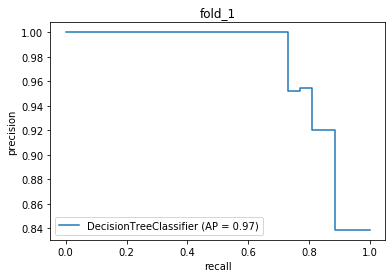

<Figure size 432x288 with 0 Axes>

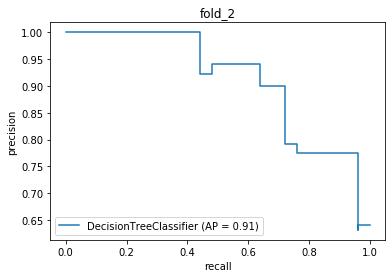

<Figure size 432x288 with 0 Axes>

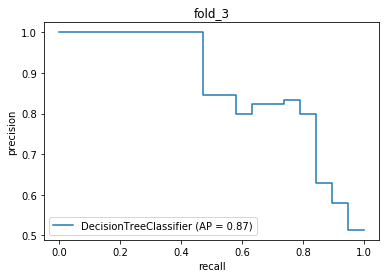

<Figure size 432x288 with 0 Axes>

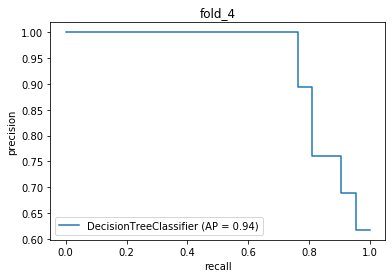

<Figure size 432x288 with 0 Axes>

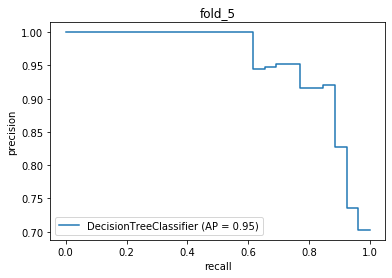

<Figure size 432x288 with 0 Axes>

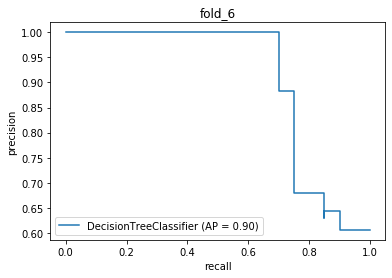

<Figure size 432x288 with 0 Axes>

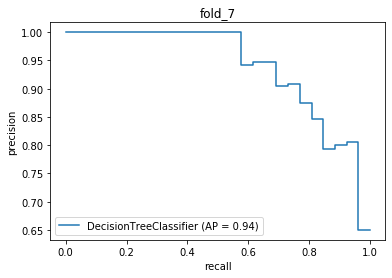

<Figure size 432x288 with 0 Axes>

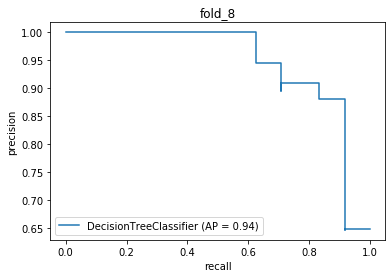

<Figure size 432x288 with 0 Axes>

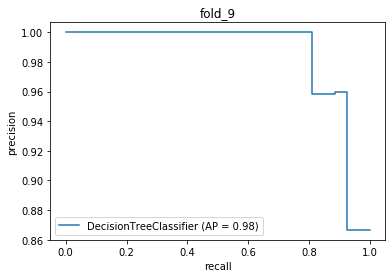

<Figure size 432x288 with 0 Axes>

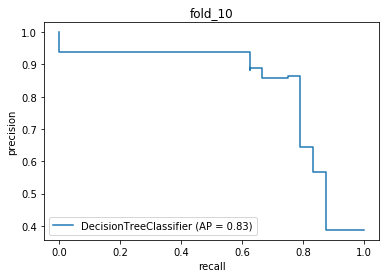

In [134]:
from sklearn.metrics import plot_precision_recall_curve 

for key, value in folds.items():
    plt.clf()
    plot_precision_recall_curve(dt, folds[key]['x_test'], folds[key]['y_test'])
    plt.title(key)
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.show()

### Promediando 

En lugar de tener que hacer cada una de estas cosas para los 10 folds existe un mecanismo que nos permite 

In [135]:
from sklearn.model_selection import cross_validate


metrics = ['precision','recall','f1','accuracy', 'roc_auc']
scores = cross_validate(dt, X_train, y_train, cv=10, scoring=metrics, n_jobs=-1)

In [136]:
print([(key, element) for key, element in scores.items()])

[('fit_time', array([0.01128244, 0.00714278, 0.01147342, 0.01424289, 0.01080465,
       0.01031899, 0.00866842, 0.00799465, 0.01036477, 0.00931716])), ('score_time', array([0.0204494 , 0.01905823, 0.02013421, 0.01502848, 0.01957107,
       0.02074003, 0.0152235 , 0.01310706, 0.01911449, 0.01785779])), ('test_precision', array([0.81818182, 0.84210526, 0.73684211, 0.9       , 0.71428571,
       0.62068966, 0.8       , 0.77777778, 0.90909091, 0.86363636])), ('test_recall', array([0.7826087 , 0.69565217, 0.60869565, 0.75      , 0.625     ,
       0.75      , 0.66666667, 0.875     , 0.83333333, 0.79166667])), ('test_f1', array([0.8       , 0.76190476, 0.66666667, 0.81818182, 0.66666667,
       0.67924528, 0.72727273, 0.82352941, 0.86956522, 0.82608696])), ('test_accuracy', array([0.85483871, 0.83870968, 0.77419355, 0.87096774, 0.75806452,
       0.72580645, 0.80645161, 0.85483871, 0.90322581, 0.87096774])), ('test_roc_auc', array([0.87904125, 0.86622074, 0.79765886, 0.86732456, 0.75767544,


In [137]:
### precision
avg_precision = pd.Series(scores['test_precision']).mean()
avg_precision

0.798260960656605

In [138]:
### recall
avg_recall = pd.Series(scores['test_recall']).mean()
avg_recall

0.7378623188405797

In [139]:
### f1 score
avg_f1_score = pd.Series(scores['test_f1']).mean()
avg_f1_score

0.7639119509389258

In [140]:
### accuracy
avg_accuracy = pd.Series(scores['test_accuracy']).mean()
avg_accuracy

0.8258064516129032

In [141]:
### roc-auc
avg_roc_auc = pd.Series(scores['test_roc_auc']).mean()
avg_roc_auc 

0.8465618215689726

Ahora probemos este modelo con el set de pruebas y comparemos esta técnica vs la de *one hold out*. 

In [142]:
from sklearn.model_selection import cross_val_predict

predicted_scores = cross_val_predict(dt, X_test, y=y_test, cv=10, n_jobs=-1, method="predict_proba")
predicted_label = cross_val_predict(dt, X_test, y=y_test, cv=10, n_jobs=-1)

### Métricas de desempeño

#### ROC y AUC

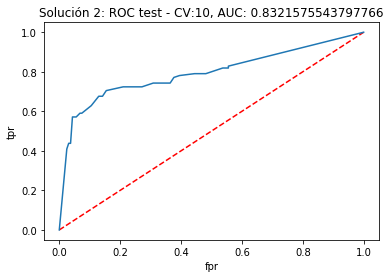

In [143]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)
   
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("Solución 2: ROC test - CV:10, AUC: " + str(roc_auc_score(y_test, predictions_scores[:,1])))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

#### Matriz de confusión


In [144]:
confusion_matrix(y_test, predictions_labels)

array([[145,  17],
       [ 31,  74]])

#### precision, recall, f1_score

In [145]:
metricas = pd.DataFrame({'threshold': thresholds, 'tpr': tpr, 'fpr': fpr})

In [146]:
metricas['tnr'] = 1 - metricas.fpr
metricas['fnr'] = 1 - metricas.tpr
metricas['precision'] = metricas.tpr/(metricas.tpr + metricas.fpr)
metricas['recall'] = metricas.tpr/(metricas.tpr + metricas.fnr)

In [147]:
metricas

,threshold,tpr,fpr,tnr,fnr,precision,recall
0,2.000000,0.000000,0.000000,1.000000,1.000000,NaN,0.000000
1,1.000000,0.409524,0.024691,0.975309,0.590476,0.943136,0.409524
2,0.857143,0.438095,0.030864,0.969136,0.561905,0.934186,0.438095
3,0.833333,0.438095,0.037037,0.962963,0.561905,0.922049,0.438095
4,0.800000,0.571429,0.043210,0.956790,0.428571,0.929699,0.571429
5,0.777778,0.571429,0.055556,0.944444,0.428571,0.911392,0.571429
6,0.714286,0.590476,0.067901,0.932099,0.409524,0.896866,0.590476
7,0.700000,0.590476,0.074074,0.925926,0.409524,0.888535,0.590476
8,0.666667,0.628571,0.104938,0.895062,0.371429,0.856937,0.628571
9,0.625000,0.676190,0.129630,0.870370,0.323810,0.839133,0.676190


### Solución 3. Cambiando los hiperparámetros del modelo y haciendo CV

En esta solución ocuparemos los métodos `GridSearchCV` y `ParameterGrid`. `ParameterGrid` nos ayudará a definir todos los hiperparámetros que queremos probar en diferentes experimentos, mientras que `GridSearchCV` nos ayudará a guardar todos los resultados obtenidos por cada uno de los experimentos al mismo tiempo que nos permite tener validación cruzada :). 

¿Cuántos modelos estamos ejecutando en la siguiente configuración de hiperparámetros?

In [148]:
from sklearn.model_selection import ParameterGrid, GridSearchCV

dt = DecisionTreeClassifier()

grid = {'min_samples_leaf': [3,5,7,11], 'criterion': ['gini', 'entropy']}

gs = GridSearchCV(dt, param_grid=grid, scoring='precision', cv=10, n_jobs=-1,
                  return_train_score=True)

gs.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [3, 5, 7, 11]},
             return_train_score=True, scoring='precision')

In [150]:
gs.best_estimator_

DecisionTreeClassifier(min_samples_leaf=5)

In [151]:
# obtiene las etiquetas del mejor predictor
predicted_labels = gs.predict(X_test)
predicted_labels[:10]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 0])

In [152]:
predicted_scores = gs.predict_proba(X_test)
predicted_scores[:10,]

array([[0.5       , 0.5       ],
       [0.85714286, 0.14285714],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.4       , 0.6       ],
       [0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.125     , 0.875     ],
       [0.42857143, 0.57142857],
       [1.        , 0.        ]])

### Métricas de desempeño

#### ROC y AUC

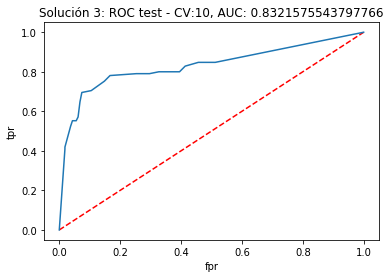

In [153]:
fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)
   
plt.clf()
plt.plot([0, 1], [0, 1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("Solución 3: ROC test - CV:10, AUC: " + str(roc_auc_score(y_test, predictions_scores[:,1])))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

#### Matriz de confusión

In [154]:
confusion_matrix(y_test, predictions_labels)

array([[145,  17],
       [ 31,  74]])

#### Accuracy

In [155]:
accuracy_score(y_test, predicted_labels)

0.8202247191011236

**Métricas**

In [156]:
metricas = pd.DataFrame({'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr})

In [157]:
metricas['tnr'] = 1 - metricas.fpr
metricas['fnr'] = 1 - metricas.tpr
metricas['precision'] = metricas.tpr/(metricas.tpr + metricas.fpr)
metricas['recall'] = metricas.tpr/(metricas.tpr + metricas.fnr)

In [158]:
metricas

,thresholds,tpr,fpr,tnr,fnr,precision,recall
0,2.000000,0.000000,0.000000,1.000000,1.000000,NaN,0.000000
1,1.000000,0.409524,0.018519,0.981481,0.590476,0.956737,0.409524
2,0.888889,0.419048,0.018519,0.981481,0.580952,0.957678,0.419048
3,0.875000,0.523810,0.037037,0.962963,0.476190,0.933962,0.523810
4,0.800000,0.552381,0.043210,0.956790,0.447619,0.927450,0.552381
5,0.750000,0.552381,0.055556,0.944444,0.447619,0.908616,0.552381
6,0.714286,0.571429,0.061728,0.938272,0.428571,0.902507,0.571429
7,0.666667,0.647619,0.067901,0.932099,0.352381,0.905102,0.647619
8,0.600000,0.695238,0.074074,0.925926,0.304762,0.903714,0.695238
9,0.571429,0.704762,0.104938,0.895062,0.295238,0.870399,0.704762


¿Cuál es el *threshold* para solo tener 5% de falsos positivos? 

Una vez que encuentras ese threshold entonces lo que haremos es que cada vez que generemos un score de predicción verificaremos si ese score en menor o igual que el que decidimos escoger, si es menor entonces le pondremos la etiqueta 0, si es mayor entonces tendrá la etiqueta 1. Nunca debes escoger el threshol 0 o 1. 

In [159]:
labels_threshold = [0 if score < 0.8 else 1 for score in predicted_scores[:,1]]
labels_threshold[:10] 

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]

In [160]:
labels_w_threshold = pd.Series(labels_threshold)
labels_w_threshold.sum()

65

In [161]:
y_labels = pd.Series(y_test)
y_labels.head()

146    0
736    1
243    0
12     0
258    1
Name: survived, dtype: int64

In [162]:
confusion_matrix(y_test, labels_threshold)

array([[155,   7],
       [ 47,  58]])

In [163]:
df = pd.DataFrame({'predicted': labels_threshold, 'true_label': y_test})
df.head()

,predicted,true_label
146,0,0
736,0,1
243,0,0
12,0,0
258,0,1


In [164]:

df['tp'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 1 and x.predicted == x.true_label else 0, axis=1)
df['fn'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 1 and x.predicted != x.true_label else 0, axis=1)
df['tn'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 0 and x.predicted == x.true_label else 0, axis=1)
df['fp'] = df[['predicted','true_label']].apply(lambda x: 1 if x.true_label == 0 and x.predicted != x.true_label else 0, axis=1)

In [165]:
df.head()

,predicted,true_label,tp,fn,tn,fp
146,0,0,0,0,1,0
736,0,1,0,1,0,0
243,0,0,0,0,1,0
12,0,0,0,0,1,0
258,0,1,0,1,0,0


In [166]:
(df.tp.sum(), df.fp.sum(), df.tn.sum(), df.fn.sum())

(58, 7, 155, 47)

In [167]:
y_labels.sum()

105

In [168]:
y_labels.filter(y_labels == 0).shape

(162,)

+ ¿Notaste que en todas las soluciones la matriz de confusión siempre es la misma? ¿Por qué sucede esto?
+ ¿Qué crees que sucedería con las métricas de desempeño si en lugar de pasar un set de pruebas con datos nuevos pasas los datos con los que entrenaste? 


### Referencias 

+ [Sklearn user guide](https://scikit-learn.org/stable/install.html)
+ [Sklearn API](https://scikit-learn.org/stable/modules/classes.html)
+ [Sklearn DecisionTreeClassifier]()
+ [Sklearn metrics](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)
+ [Sklearn model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
+ [Sklearn GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)
+ [Sklearn KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
+ [Sklearn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)